# CREACIÓN DEL DATAMART ANALÍTICO

## IMPORTE DE LIBRERÍAS

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCcompleter.greedy = True

## CARGA DE LA BASE DE DATOS

Crear la conexión a la base de datos

In [10]:
con = sa.create_engine('sqlite:///../Datos/AIRBNB.db')

En caso de que se este tratando con una base de datos nueva, es posible usar el método Inspect de sqlalchemy para obtener el nombre de las tablas encontradas en la BD.

In [11]:
insp = sa.inspect(con)
tablas = insp.get_table_names()
tablas

['df', 'df_preparado', 'listings', 'listings_D']

A la hora de ingresar las tablas al notebook se presentan dos opciones, ingresar las tablas de forma manual, lo cual puede ser conveniente cuando se manejan pocos conjuntos de datos, o se puede automatizar el proceso usando un ciclo for y el método exec, tal como es mostrado a continuación:

### 1.Carga Manual

In [12]:
listings = pd.read_sql('listings', con)
listings_D = pd.read_sql('listings_D', con)

### 2. Carga Automática

In [13]:
for tabla in tablas:
    exec(f'{tabla} = pd.read_sql(tabla,con)')

In [14]:
for tabla in tablas:
    print(tabla + ': ' +  str(eval(tabla).shape))

df: (21395, 22)
df_preparado: (21395, 32)
listings: (25543, 19)
listings_D: (25543, 75)


## DATOS EXTERNOS

Para el desarrollo de esta actividad fue necesario la utilización de datos externos para la obtención de los precios por m2 de viviendas por distritos, los datos fueron obtenidos gracias a los reportes entregados por Idealista dentro de su portal web.

In [15]:
precio_m2 = (pd.read_csv('../Datos/idealista.csv')
 .loc[1:21, ['table__cell', 'icon-elbow']]
 .rename(columns = {'table__cell': 'precio_m2', 'icon-elbow': 'distrito'}))

precio_m2

,precio_m2,distrito
1,4.524 €/m2,Arganzuela
2,3.406 €/m2,Barajas
3,2.572 €/m2,Carabanchel
4,5.877 €/m2,Centro
5,5.863 €/m2,Chamartín
6,6.124 €/m2,Chamberí
7,3.459 €/m2,Ciudad Lineal
8,3.845 €/m2,Fuencarral
9,4.067 €/m2,Hortaleza
10,2.592 €/m2,Latina


In [16]:
precio_m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 1 to 21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   precio_m2  21 non-null     object
 1   distrito   21 non-null     object
dtypes: object(2)
memory usage: 468.0+ bytes


Antes de continuar con el ejercicio se debe realizar la limpieza de los datos, aplicando el siguiente procedimiento:
    
1. Se debe sustraer la unidad
2. Se debe sustraer los puntos separador de miles
3. Se debe cambiar la tipología del precio a tipo entero

In [17]:
precio_m2['precio_m2'] = precio_m2.precio_m2.str.split(expand = True)[0].str.replace('.', '', regex = False).astype('int64')
precio_m2

,precio_m2,distrito
1,4524,Arganzuela
2,3406,Barajas
3,2572,Carabanchel
4,5877,Centro
5,5863,Chamartín
6,6124,Chamberí
7,3459,Ciudad Lineal
8,3845,Fuencarral
9,4067,Hortaleza
10,2592,Latina


In [18]:
precio_m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 1 to 21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   precio_m2  21 non-null     int64 
 1   distrito   21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


## ANÁLISIS DE LA TABLA BASE

In [19]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Simon,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,85.0,5,106,2023-10-16,0.63,1,22,4,None
1,1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Dana,Centro,Sol,40.41476,-3.70418,Entire home/apt,65.0,5,172,2022-09-26,1.05,3,0,0,None
2,2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Abdel,Latina,Cármenes,40.40381,-3.74130,Private room,31.0,4,33,2018-07-15,0.30,2,135,0,None
3,3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Alvaro,Centro,Universidad,40.42183,-3.70529,Entire home/apt,94.0,5,33,2023-11-06,0.30,1,168,8,None
4,4,30959,Loft in Madrid · ★4.38 · 1 bedroom · 1 bed · 1...,132883,Angela,Centro,Embajadores,40.41259,-3.70105,Entire home/apt,NaN,3,8,2017-05-30,0.08,1,0,0,None


In [20]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           25543 non-null  int64  
 1   id                              25543 non-null  int64  
 2   name                            25543 non-null  object 
 3   host_id                         25543 non-null  int64  
 4   host_name                       25532 non-null  object 
 5   neighbourhood_group             25543 non-null  object 
 6   neighbourhood                   25543 non-null  object 
 7   latitude                        25543 non-null  float64
 8   longitude                       25543 non-null  float64
 9   room_type                       25543 non-null  object 
 10  price                           21734 non-null  float64
 11  minimum_nights                  25543 non-null  int64  
 12  number_of_reviews               

### DEFINICIÓN DE VARIABLES

Se procede a eliminar aquellas variables que no necesitaremos directamente para nuestros objetivos.

In [21]:
a_eliminar = ['index', 'host_name', 'number_of_reviews', 'last_review', 'reviews_per_month', 'number_of_reviews_ltm', 'license']
listings.drop(columns = a_eliminar, inplace = True)

listings

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,85.0,5,1,22
1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Centro,Sol,40.414760,-3.704180,Entire home/apt,65.0,5,3,0
2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31.0,4,2,135
3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,94.0,5,1,168
4,30959,Loft in Madrid · ★4.38 · 1 bedroom · 1 bed · 1...,132883,Centro,Embajadores,40.412590,-3.701050,Entire home/apt,NaN,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25538,1046219783290634155,Rental unit in Madrid · ★New · 2 bedrooms · 3 ...,529402573,Usera,Zofío,40.384658,-3.714106,Entire home/apt,120.0,1,56,303
25539,1045519419976898566,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,529402573,Salamanca,Guindalera,40.438832,-3.671323,Entire home/apt,120.0,1,56,189
25540,1046222300986271054,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,31772865,Tetuán,Castillejos,40.458234,-3.695566,Entire home/apt,171.0,1,42,318
25541,1046239141714406672,Rental unit in Madrid · ★New · 2 bedrooms · 4 ...,346367515,Chamberí,Arapiles,40.433040,-3.711060,Entire home/apt,74.0,31,237,326


Luego se procede a cambiar el tipo de dato de las variables *neighbourhood_group*, *neighbourhood*, *room_type* a tipo categorica.

In [22]:
for variable in ['neighbourhood_group', 'neighbourhood', 'room_type']:
    listings[variable] = listings[variable].astype('category')

### ANÁLISIS DE NULOS

In [23]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              25543 non-null  int64   
 1   name                            25543 non-null  object  
 2   host_id                         25543 non-null  int64   
 3   neighbourhood_group             25543 non-null  category
 4   neighbourhood                   25543 non-null  category
 5   latitude                        25543 non-null  float64 
 6   longitude                       25543 non-null  float64 
 7   room_type                       25543 non-null  category
 8   price                           21734 non-null  float64 
 9   minimum_nights                  25543 non-null  int64   
 10  calculated_host_listings_count  25543 non-null  int64   
 11  availability_365                25543 non-null  int64   
dtypes: category(3), fl

Por la columna Non-null del info() se aprecia que la variable precio contiene casí 4000 registros nulos, por lo que se deciden eliminar de la base de datos para que no afecte los resultados del análisis.

In [24]:
listings.dropna(inplace = True)

In [25]:
listings.duplicated().sum()

0

In [26]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21734 entries, 0 to 25542
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   id                              21734 non-null  int64   
 1   name                            21734 non-null  object  
 2   host_id                         21734 non-null  int64   
 3   neighbourhood_group             21734 non-null  category
 4   neighbourhood                   21734 non-null  category
 5   latitude                        21734 non-null  float64 
 6   longitude                       21734 non-null  float64 
 7   room_type                       21734 non-null  category
 8   price                           21734 non-null  float64 
 9   minimum_nights                  21734 non-null  int64   
 10  calculated_host_listings_count  21734 non-null  int64   
 11  availability_365                21734 non-null  int64   
dtypes: category(3), float64

### ANÁLISIS DE VARIABLES

#### VARIABLES CATEGÓRICAS

Para este tipo de variables se contempla en mayor medida la frecuencia con la cual se reiteran un registro dentro de un conjunto de datos.

In [27]:
listings.neighbourhood_group.value_counts()

neighbourhood_group
Centro                   9427
Salamanca                1472
Chamberí                 1448
Tetuán                   1223
Arganzuela               1027
Carabanchel               792
Retiro                    749
Ciudad Lineal             694
Chamartín                 654
Puente de Vallecas        622
Latina                    586
Usera                     575
Moncloa - Aravaca         517
Hortaleza                 466
San Blas - Canillejas     459
Fuencarral - El Pardo     309
Villaverde                228
Moratalaz                 157
Barajas                   147
Villa de Vallecas         104
Vicálvaro                  78
Name: count, dtype: int64

In [28]:
listings.neighbourhood.value_counts()

neighbourhood
Embajadores    2538
Universidad    2021
Palacio        1620
Sol            1188
Justicia       1098
               ... 
Aeropuerto        8
Palomas           8
Amposta           8
Valdemarín        8
El Pardo          4
Name: count, Length: 125, dtype: int64

In [29]:
listings.room_type.value_counts()

room_type
Entire home/apt    14566
Private room        6720
Shared room          351
Hotel room            97
Name: count, dtype: int64

Aquí se presenta una particularidad, en el listado se esta contemplando cuarto de hoteles, concepto que sale del foco que se quiere trabajar dentro del grupo de inversión, por lo que se procede a descartar este tipo de habitaciones.

In [30]:
listings = listings.loc[listings.room_type != 'Hotel room']

In [31]:
listings.shape

(21637, 12)

#### VARIABLES NUMÉRICAS

Para el caso de estudio propuesto se considera útil analizar las variables que van desde el precio de la habitación hasta, el número de días que dicha habitación se encuentra disponible en el año.

In [32]:
listings.iloc[:, 8:12].describe().T

,count,mean,std,min,25%,50%,75%,max
price,21637.0,128.608633,270.504130,8.0,59.0,90.0,137.0,21000.0
minimum_nights,21637.0,8.101169,35.170252,1.0,1.0,2.0,3.0,1125.0
calculated_host_listings_count,21637.0,28.510376,62.026800,1.0,1.0,3.0,18.0,291.0
availability_365,21637.0,173.098489,134.393793,0.0,31.0,170.0,313.0,365.0


Conclusiones:

* En el precio hay que revisar mínimos y máximos
* En minimum_nights hay que revisar los máximos
* En calculated_host_listings_count hay que revisar los máximos

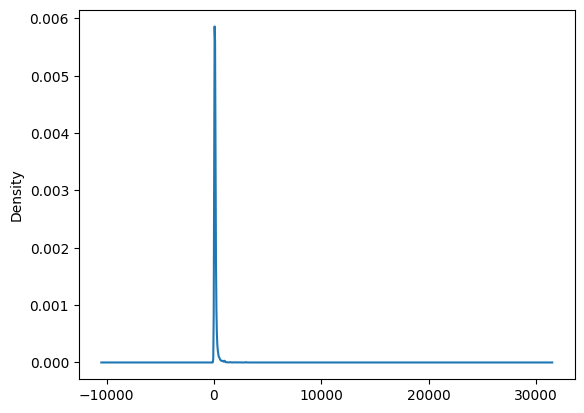

In [33]:
listings.price.plot.kde();

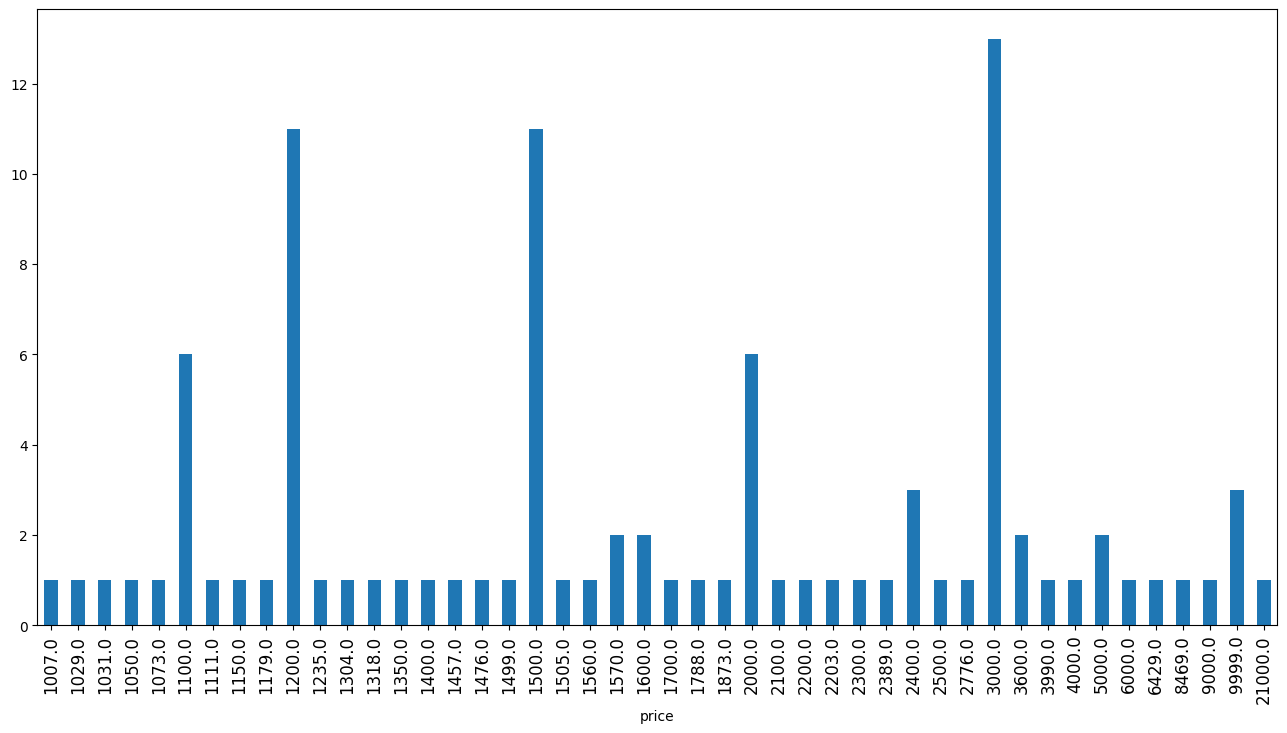

In [34]:
plt.figure(figsize = (16,8))
listings.price.loc[listings.price > 1000].value_counts().sort_index().plot.bar()
plt.xticks(size = 12);

Conclusión: 
    
* el valor 9999 normalmente suele ser una forma de imputar nulos, pero en este caso su frecuencia se encuentra dentro de otros valores que pueden ser válidos, como el 21000, así que no se tocará.

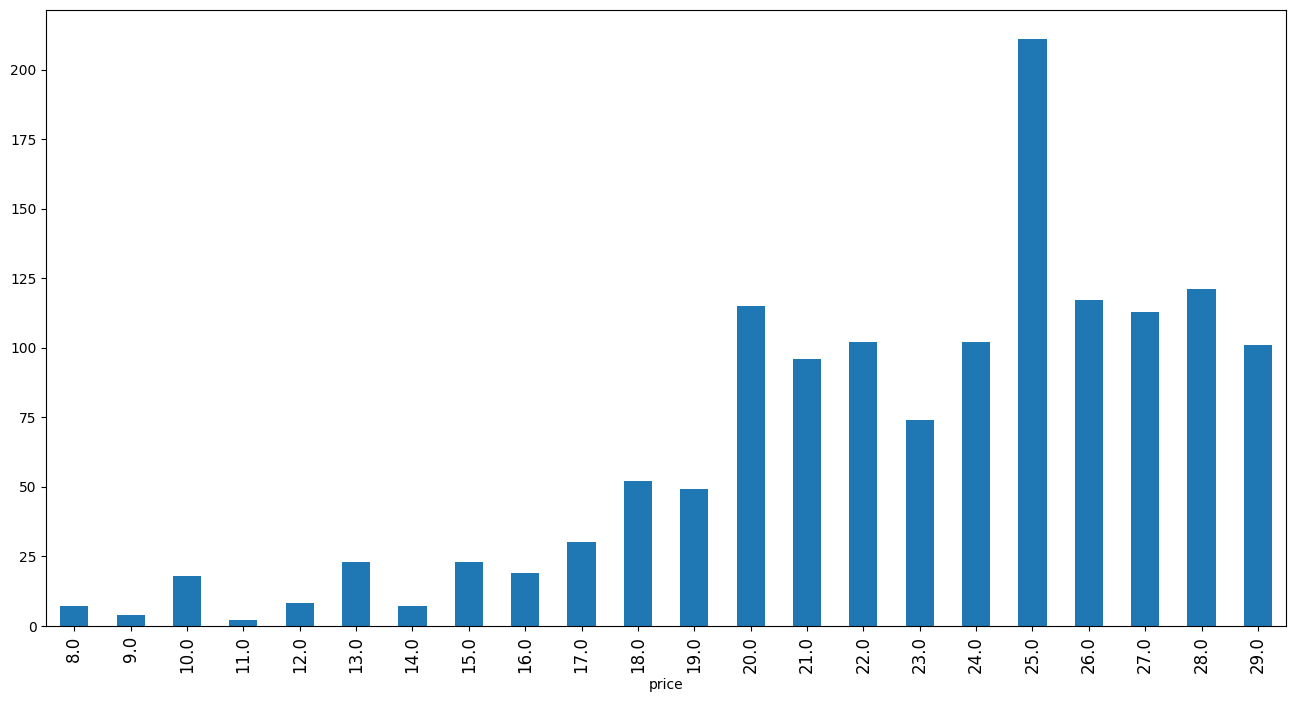

In [35]:
plt.figure(figsize = (16,8))
listings.price.loc[listings.price < 30].value_counts().sort_index().plot.bar()
plt.xticks(size = 12);

Dentro de los alcaances del grupo inversionista no se considera rentable la compra de inmuebles cuya rentabilidad de alquiler sea inferior a 20 euros, por lo que se proceden a excluir del listado a analizar.

In [36]:
listings = listings.loc[listings.price > 19]
listings

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,85.0,5,1,22
1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Centro,Sol,40.414760,-3.704180,Entire home/apt,65.0,5,3,0
2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31.0,4,2,135
3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,94.0,5,1,168
5,26825,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,29.0,3,1,295
...,...,...,...,...,...,...,...,...,...,...,...,...
25538,1046219783290634155,Rental unit in Madrid · ★New · 2 bedrooms · 3 ...,529402573,Usera,Zofío,40.384658,-3.714106,Entire home/apt,120.0,1,56,303
25539,1045519419976898566,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,529402573,Salamanca,Guindalera,40.438832,-3.671323,Entire home/apt,120.0,1,56,189
25540,1046222300986271054,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,31772865,Tetuán,Castillejos,40.458234,-3.695566,Entire home/apt,171.0,1,42,318
25541,1046239141714406672,Rental unit in Madrid · ★New · 2 bedrooms · 4 ...,346367515,Chamberí,Arapiles,40.433040,-3.711060,Entire home/apt,74.0,31,237,326


## ANÁLISIS DE LA TABLA DETALLADA

### ANÁLISIS GENERAL

In [37]:
listings_D.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6369,https://www.airbnb.com/rooms/6369,20231215032748,2023-12-15,city scrape,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,NaN,None,https://a0.muscache.com/pictures/683224/4cc318...,13660,...,4.86,4.84,4.86,None,f,1,0,1,0,0.63
1,21853,https://www.airbnb.com/rooms/21853,20231215032748,2023-12-15,city scrape,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,NaN,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,4.82,4.21,4.67,None,f,2,0,2,0,0.30
2,24805,https://www.airbnb.com/rooms/24805,20231215032748,2023-12-15,city scrape,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,NaN,"The area is next to the Gran Via, so people li...",https://a0.muscache.com/pictures/miso/Hosting-...,346366726,...,4.97,5.00,4.76,None,f,1,1,0,0,0.30
3,26825,https://www.airbnb.com/rooms/26825,20231215032748,2023-12-15,city scrape,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,NaN,"Es un barrio muy tranquilo, en una zona de Mad...",https://a0.muscache.com/pictures/149358/218d5b...,114340,...,4.72,4.73,4.77,None,f,1,0,1,0,1.18
4,30320,https://www.airbnb.com/rooms/30320,20231215032748,2023-12-15,previous scrape,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,NaN,None,https://a0.muscache.com/pictures/336868/f67409...,130907,...,4.78,4.90,4.69,None,f,3,3,0,0,1.05


In [38]:
listings_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25543 non-null  int64  
 1   listing_url                                   25543 non-null  object 
 2   scrape_id                                     25543 non-null  int64  
 3   last_scraped                                  25543 non-null  object 
 4   source                                        25543 non-null  object 
 5   name                                          25543 non-null  object 
 6   description                                   0 non-null      float64
 7   neighborhood_overview                         13137 non-null  object 
 8   picture_url                                   25542 non-null  object 
 9   host_id                                       25543 non-null 

### SELECCIÓN DE VARIABLES

Se procede a seleccionar solo las columnas de interés para el análisis a realizar.

In [39]:
a_incluir = ['id', 
             'host_is_superhost', 
             'accommodates',
             'bedrooms',
             'beds', 
             'number_of_reviews', 
             'review_scores_rating', 
             'review_scores_communication', 
             'review_scores_location']

listings_D = listings_D.loc[:, a_incluir]

listings_D

,id,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,t,2,NaN,1.0,106,4.88,4.86,4.84
1,21853,f,1,NaN,1.0,33,4.58,4.82,4.21
2,24805,f,3,NaN,1.0,33,4.91,4.97,5.00
3,26825,t,1,NaN,1.0,196,4.72,4.72,4.73
4,30320,f,2,NaN,2.0,172,4.63,4.78,4.90
...,...,...,...,...,...,...,...,...,...
25538,1045513235996315049,f,6,NaN,3.0,0,NaN,NaN,NaN
25539,1045517912453641702,f,8,NaN,4.0,0,NaN,NaN,NaN
25540,1045518757044319450,f,9,NaN,5.0,0,NaN,NaN,NaN
25541,1045519103468143325,f,4,NaN,3.0,0,NaN,NaN,NaN


Se revisa la tipología de las variables seleccionadas.

In [40]:
listings_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           25543 non-null  int64  
 1   host_is_superhost            25363 non-null  object 
 2   accommodates                 25543 non-null  int64  
 3   bedrooms                     0 non-null      float64
 4   beds                         25238 non-null  float64
 5   number_of_reviews            25543 non-null  int64  
 6   review_scores_rating         20216 non-null  float64
 7   review_scores_communication  20215 non-null  float64
 8   review_scores_location       20212 non-null  float64
dtypes: float64(5), int64(3), object(1)
memory usage: 1.8+ MB


Se define la variable de *host_is_superhost* como una variable categórica.

In [41]:
listings_D['host_is_superhost'] = listings_D.host_is_superhost.astype('category')

In [42]:
listings_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           25543 non-null  int64   
 1   host_is_superhost            25363 non-null  category
 2   accommodates                 25543 non-null  int64   
 3   bedrooms                     0 non-null      float64 
 4   beds                         25238 non-null  float64 
 5   number_of_reviews            25543 non-null  int64   
 6   review_scores_rating         20216 non-null  float64 
 7   review_scores_communication  20215 non-null  float64 
 8   review_scores_location       20212 non-null  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 1.6 MB


### ANÁLISIS DE NULOS

In [43]:
listings_D.isna().sum()

id                                 0
host_is_superhost                180
accommodates                       0
bedrooms                       25543
beds                             305
number_of_reviews                  0
review_scores_rating            5327
review_scores_communication     5328
review_scores_location          5331
dtype: int64

Conclusiones:

* host_is_superhost tiene muy pocos nulos y no es una variables super relevante, así que no se interviene
* beds: Se va a proceder a acondicionarla a partir de la variable accomodates
* bedrooms sí es una variable importante para el caso de estudio, por lo que se intentará acondicionar los valores nulos a través de proxies como accomodates o beds

Se procede a validar si es viable determinar el número de camas en un complejo a partir del número de alquilantes a los que puede acomodar este complejo.

In [44]:
pd.crosstab(listings_D.beds, listings_D.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
1.0,3668,7487,553,730,21,24,2,1,0,5,0,0,0,0,0,1
2.0,151,1196,1651,3469,147,152,3,10,0,1,0,0,1,0,0,1
3.0,32,80,277,1218,565,888,35,32,0,2,0,0,0,0,0,0
4.0,38,39,22,282,276,654,126,187,8,4,0,1,0,0,0,0
5.0,10,5,3,25,68,181,91,120,22,43,1,4,0,0,0,0
6.0,21,4,4,5,7,65,18,86,13,34,7,15,0,2,0,0
7.0,2,0,0,1,1,7,10,22,17,20,3,11,1,4,0,0
8.0,11,8,1,1,1,4,0,20,6,20,2,10,3,2,0,1
9.0,0,1,0,0,0,0,0,3,5,10,1,4,0,2,1,3


Parece que sí es posible hacer una asignación mas o menos directa. Leyendo la matriz en vertical se puede apreciar que:

* una o dos personas se suelen corresponder con una cama
* tres o cuatro personas se suelen corresponder con dos camas
* cinco o seis personas se suelen corresponder con tres camas
* a más de 6 personas le vamos a poner cuatro camas

In [45]:
listings_D.beds.value_counts(dropna = False)

beds
1.0     12492
2.0      6782
3.0      3129
4.0      1637
5.0       573
NaN       305
6.0       281
7.0        99
8.0        90
10.0       59
12.0       31
9.0        30
11.0        9
14.0        8
20.0        6
13.0        5
16.0        3
17.0        1
15.0        1
40.0        1
30.0        1
Name: count, dtype: int64

In [46]:
def imputar_nulos(registro):
    # Lista de Condiciones
   
    condiciones = [(registro.accommodates <= 2),
               (registro.accommodates > 2) & (registro.accommodates <= 4),
               (registro.accommodates > 4) & (registro.accommodates <= 6),
               (registro.accommodates > 6)]
    resultados = [1, 2, 3, 4]
    
    # Salida
    
    return (np.select(condiciones,resultados,default = -999))

listings_D.loc[listings_D.beds.isna(), 'beds'] = listings_D.loc[listings_D.beds.isna()].apply(imputar_nulos, axis = 1).astype('float64')

In [47]:
listings_D.beds.value_counts(dropna = False)

beds
1.0     12730
2.0      6834
3.0      3140
4.0      1641
5.0       573
6.0       281
7.0        99
8.0        90
10.0       59
12.0       31
9.0        30
11.0        9
14.0        8
20.0        6
13.0        5
16.0        3
17.0        1
15.0        1
40.0        1
30.0        1
Name: count, dtype: int64

Se crea una función para imputar los nulos de bedrooms en base a accommodates

In [48]:
def imputar_nulos(registro):
    # Lista de Condiciones
   
    condiciones = [(registro.beds <= 2),
               (registro.beds > 2) & (registro.beds <= 4),
               (registro.beds > 4) & (registro.beds <= 6),
               (registro.beds > 6)]
    resultados = [1, 2, 3, 4]
    
    # Salida
    
    return (np.select(condiciones,resultados,default = -999))

listings_D.loc[listings_D.bedrooms.isna(), 'bedrooms'] = listings_D.loc[listings_D.bedrooms.isna()].apply(imputar_nulos, axis = 1).astype('float64')

In [49]:
listings_D.bedrooms.value_counts(dropna = False)

bedrooms
1.0    19564
2.0     4781
3.0      854
4.0      344
Name: count, dtype: int64

### ANÁLISIS DE DUPLICADOS

In [50]:
listings_D.duplicated().sum()

0

In [51]:
listings_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25543 entries, 0 to 25542
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           25543 non-null  int64   
 1   host_is_superhost            25363 non-null  category
 2   accommodates                 25543 non-null  int64   
 3   bedrooms                     25543 non-null  float64 
 4   beds                         25543 non-null  float64 
 5   number_of_reviews            25543 non-null  int64   
 6   review_scores_rating         20216 non-null  float64 
 7   review_scores_communication  20215 non-null  float64 
 8   review_scores_location       20212 non-null  float64 
dtypes: category(1), float64(5), int64(3)
memory usage: 1.6 MB


### ANÁLISIS DE LAS VARIABLES CATEGÓRICAS

In [52]:
listings_D.host_is_superhost.value_counts()

host_is_superhost
f    19676
t     5687
Name: count, dtype: int64

### ANÁLISIS DE VARIABLES NUMÉRICAS

In [53]:
listings_D.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
id,25543.0,4.159907e+17,4.324774e+17,6369.0,31148623.50,53976090.00,8.698655e+17,1.046255e+18
accommodates,25543.0,3.126727e+00,1.920497e+00,1.0,2.00,2.00,4.000000e+00,1.600000e+01
bedrooms,25543.0,1.294445e+00,5.961824e-01,1.0,1.00,1.00,1.000000e+00,4.000000e+00
beds,25543.0,1.962338e+00,1.450671e+00,1.0,1.00,2.00,2.000000e+00,4.000000e+01
number_of_reviews,25543.0,4.286904e+01,8.104807e+01,0.0,1.00,10.00,4.600000e+01,9.940000e+02
review_scores_rating,20216.0,4.640384e+00,4.836087e-01,0.0,4.53,4.75,4.920000e+00,5.000000e+00
review_scores_communication,20215.0,4.759503e+00,4.435415e-01,1.0,4.72,4.89,5.000000e+00,5.000000e+00
review_scores_location,20212.0,4.746825e+00,3.948586e-01,1.0,4.67,4.88,4.990000e+00,5.000000e+00


No se observan particularidades por atender en este apartado

En este punto ya se ha detectado y corregido los principales problemas de calidad de datos así que se pasa a crear el datamart analítico integrando las tablas.

## DATAMART ANALÍTICO

Se tienen 2 tablas principales:

* listings
* listings_det

Se conoce que ambas comparten el campo id, por tanto es posible cruzarla por utilizando esa variable.

La tabla principal es listings, ya que la de detalle lo que hace brinda información complementaría.

Por tanto la tabla debe mandar en la integración es listings.

Además tambien se tiene la tabla del precio, que en este caso cruza conceptualmente con listings a través del distrito (neighbourhood_group).

Aunque no se ha comprobado todavía que los literales sean iguales, por tanto quizá será necesario hacer alguna corrección manual.

Se comienza el procedimiento uniendo las dos tablas principales.

Dado que va a mandar la tabla listings el resultado final tendrá que tener tantas filas como listings y tantas columnas como las de ambas tablas (menos 1 por el id que se quedará como una única variable)

In [54]:
df = pd.merge(listings, listings_D, how = 'left', on = 'id')
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,Rental unit in Madrid · ★4.88 · 1 bedroom · 1 ...,13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,85.0,5,1,22,t,2,1.0,1.0,106,4.88,4.86,4.84
1,30320,Rental unit in Madrid · ★4.63 · 1 bedroom · 2 ...,130907,Centro,Sol,40.414760,-3.704180,Entire home/apt,65.0,5,3,0,f,2,1.0,2.0,172,4.63,4.78,4.90
2,21853,Rental unit in Madrid · ★4.58 · 1 bedroom · 1 ...,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31.0,4,2,135,f,1,1.0,1.0,33,4.58,4.82,4.21
3,24805,Rental unit in Madrid · ★4.91 · 6 bedrooms · 1...,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,94.0,5,1,168,f,3,1.0,1.0,33,4.91,4.97,5.00
4,26825,Home in Madrid · ★4.72 · 1 bedroom · 1 bed · 1...,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,29.0,3,1,295,t,1,1.0,1.0,196,4.72,4.72,4.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21390,1046219783290634155,Rental unit in Madrid · ★New · 2 bedrooms · 3 ...,529402573,Usera,Zofío,40.384658,-3.714106,Entire home/apt,120.0,1,56,303,f,4,2.0,3.0,0,NaN,NaN,NaN
21391,1045519419976898566,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,529402573,Salamanca,Guindalera,40.438832,-3.671323,Entire home/apt,120.0,1,56,189,f,2,1.0,1.0,0,NaN,NaN,NaN
21392,1046222300986271054,Rental unit in Madrid · ★New · 1 bedroom · 1 b...,31772865,Tetuán,Castillejos,40.458234,-3.695566,Entire home/apt,171.0,1,42,318,f,2,1.0,1.0,0,NaN,NaN,NaN
21393,1046239141714406672,Rental unit in Madrid · ★New · 2 bedrooms · 4 ...,346367515,Chamberí,Arapiles,40.433040,-3.711060,Entire home/apt,74.0,31,237,326,f,4,2.0,4.0,0,NaN,NaN,NaN


Ahora se procede a plantear un método para incorporar la información externa del precio por metro cuadrado.

Para ello lo primero es analizar los valores de la variable distrito en ambas tablas, ya que necesitan coincidir para que podamos cruzarlos.

En df la variable es categórica, así que para sacar los niveles se tiene que usar .categories

In [55]:
precio_m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 1 to 21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   precio_m2  21 non-null     int64 
 1   distrito   21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


In [56]:
precio_m2.distrito.unique()

array(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral', 'Hortaleza', 'Latina',
       'Moncloa', 'Moratalaz', 'Puente de Vallecas', 'Retiro',
       'Salamanca', 'San Blas', 'Tetuán', 'Usera', 'Vicálvaro',
       'Villa de Vallecas', 'Villaverde'], dtype=object)

In [57]:
df.neighbourhood_group.unique().categories

Index(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza',
       'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas',
       'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera',
       'Vicálvaro', 'Villa de Vallecas', 'Villaverde'],
      dtype='object')

Comparando parece todo igual excepto:

* Fuencarral - El Pardo
* Moncloa - Aravaca
* San Blas - Canillejas

Por tanto se reemplazará los valores en precio_m2 para que sean iguales a los de df y finalmente se cruzaran las tablas.

In [58]:
precio_m2.distrito = precio_m2.distrito.map({'Fuencarral':'Fuencarral - El Pardo', 
                                             'San Blas':'San Blas - Canillejas',
                                             'Moncloa':'Moncloa - Aravaca'}).fillna(precio_m2.distrito)

precio_m2

,precio_m2,distrito
1,4524,Arganzuela
2,3406,Barajas
3,2572,Carabanchel
4,5877,Centro
5,5863,Chamartín
6,6124,Chamberí
7,3459,Ciudad Lineal
8,3845,Fuencarral - El Pardo
9,4067,Hortaleza
10,2592,Latina


In [59]:
df = pd.merge(df, precio_m2, how = 'left', left_on = 'neighbourhood_group', right_on = 'distrito')

Se comprueba que no se hayan generado nulos en la unión.

In [60]:
df.precio_m2.isna().sum()

0

## GUARDAR EN BASE DE DATOS

Con el tablón de análisis ajustado se procede a guardar el proceso realizado en la base de datos.

In [61]:
df.to_sql('df', con = con, if_exists = 'replace', index = False)

21395